"Reconstructing and Generating Human Faces using Latent Representations in VAE"

In [1]:
import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()


0

In [14]:
import numpy as np
import cv2
import os
from tqdm import tqdm

dataset_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

IMG_SIZE = 128  
MAX_IMAGES = 10000 
images = []
image_files = os.listdir(dataset_path)[:MAX_IMAGES] 

for img_name in tqdm(image_files):
    img_path = os.path.join(dataset_path, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Skipping file: {img_name} (corrupted)")
        continue  
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  
    
    images.append(img)

images = np.array(images)
print(f"{images.shape[0]} images of shape {images.shape[1:]}")

100%|██████████| 10000/10000 [00:23<00:00, 419.54it/s]


10000 images of shape (128, 128, 3)


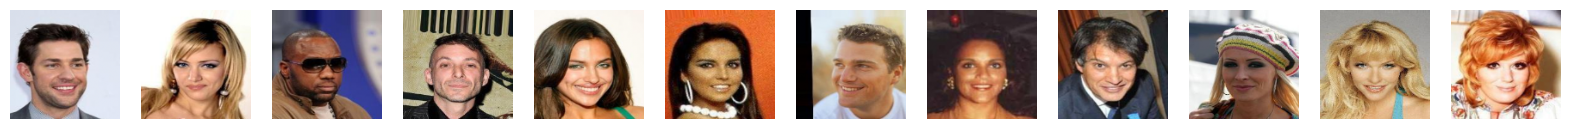

In [16]:
import matplotlib.pyplot as plt

def show_images(images, num=7):
    plt.figure(figsize=(20,15 ))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

show_images(images, num=12)


#  Variation Autoencoder (VAE)


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

images = np.array(images, dtype=np.float32)

images = images.reshape((-1, 128, 128, 3))  

X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (8000, 128, 128, 3)
Validation set shape: (2000, 128, 128, 3)


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SHAPE = (128, 128, 3)
LATENT_DIM = 256 

In [20]:
def Vencoder():
    inputs = keras.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var])

    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [21]:
def Vdecoder():
    latent_inputs = keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
    x = layers.Reshape((16, 16, 256))(x)

    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x)  # 32x32
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)   # 64x64
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)   # 128x128

    outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)  

    decoder = keras.Model(latent_inputs, outputs, name="decoder")
    return decoder

In [22]:
encoder = Vencoder()
decoder = Vdecoder()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse")

history = vae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=50, batch_size=32)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0666 - val_loss: 0.0229
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0213 - val_loss: 0.0166
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0104 - val_loss: 0.0110
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0091 - val_loss: 0.0105
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0086 - val_loss: 0.0105
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0082 - val_loss: 0.0102
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pickle

pickle_filename = 'vae_model.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(vae, file)

print(f"Model saved as {pickle_filename}")

In [31]:
import numpy as np

reconstructed = vae.predict(X_val)

X_val_rounded = np.round(X_val)
reconstructed_rounded = np.round(reconstructed)

accuracy = np.mean(X_val_rounded == reconstructed_rounded)
print("Reconstruction Accuracy:", accuracy)


import tensorflow as tf
import numpy as np

def compute_ssim(original, reconstructed):
    ssim_scores = tf.image.ssim(original, reconstructed, max_val=1.0)
    return ssim_scores.numpy()

ssim_scores = compute_ssim(X_val, reconstructed)
print("Average SSIM: ", np.mean(ssim_scores))



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Reconstruction Accuracy: 0.911851806640625
Average SSIM:  0.5400144


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


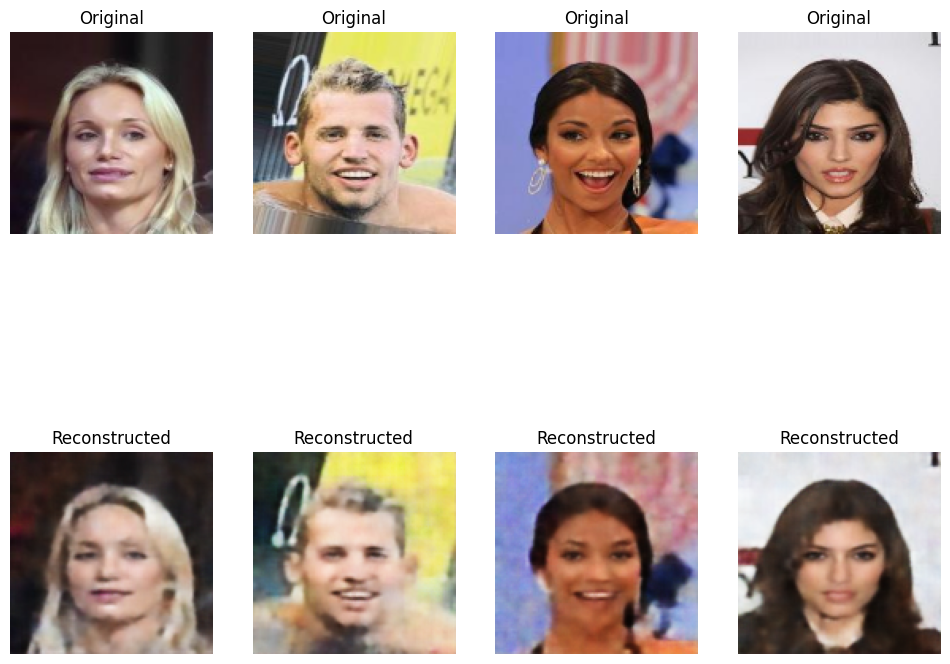

In [42]:
import matplotlib.pyplot as plt

num_images = 4
indices = np.random.choice(len(X_train), num_images)  
test_images = X_train[indices]

encoded, _, _ = encoder.predict(test_images)
decoded_images = decoder.predict(encoded)

fig, axes = plt.subplots(2, num_images, figsize=(12, 10))

for i in range(num_images):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.show()


Inference:

ariational Autoencoder (VAE) with high reconstruction accuracy (~0.91) and steady loss decreasing over 50 epochs, indicating the model can effectively reconstruct inputs while learning a meaningful latent representation.

-The structural similarity score (SSIM) of 0.54 shows the reconstructions keep important details but can improve in fine structure.

-Training and validation loss steadily decrease, showing the model is learning well and not overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


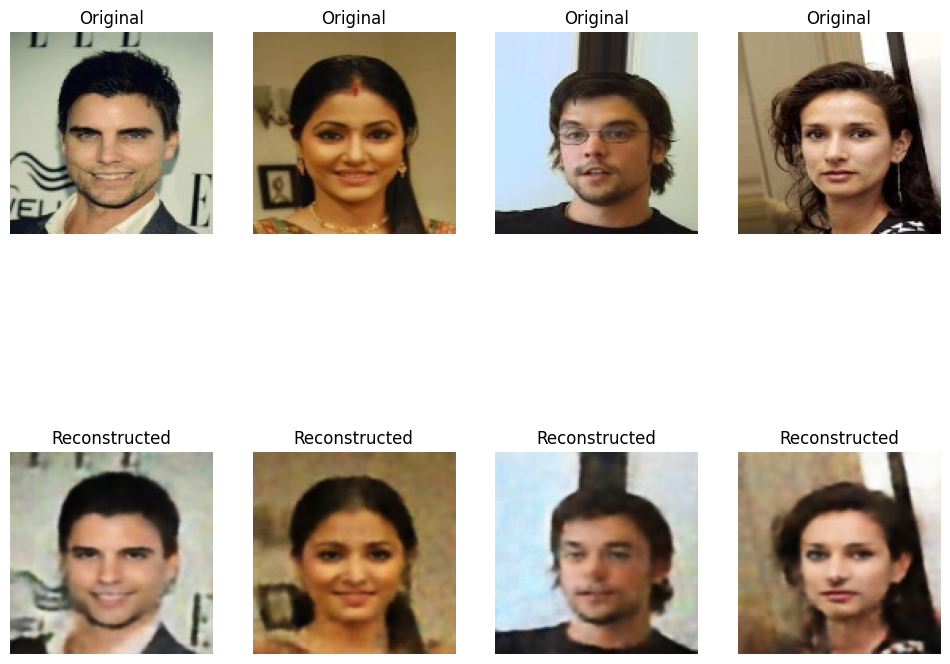

In [77]:
import matplotlib.pyplot as plt

num_images = 4
indices = np.random.choice(len(X_train), num_images)  
test_images = X_train[indices]

encoded, _, _ = encoder.predict(test_images)
decoded_images = decoder.predict(encoded)

fig, axes = plt.subplots(2, num_images, figsize=(12, 10))

for i in range(num_images):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


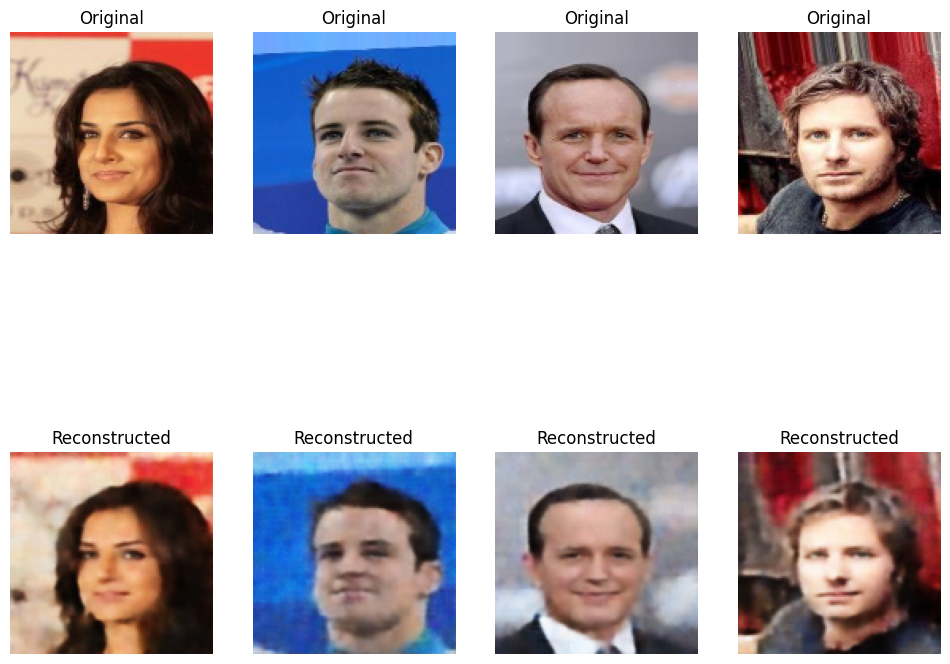

In [46]:
import matplotlib.pyplot as plt

num_images = 4
indices = np.random.choice(len(X_train), num_images)  
test_images = X_train[indices]

encoded, _, _ = encoder.predict(test_images)
decoded_images = decoder.predict(encoded)

fig, axes = plt.subplots(2, num_images, figsize=(12, 10))

for i in range(num_images):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


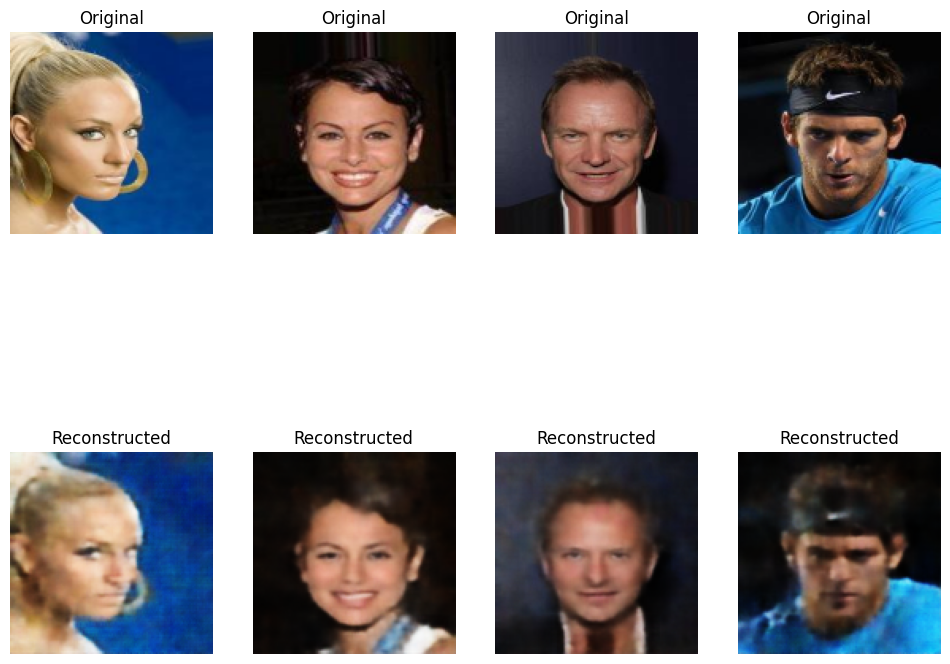

In [56]:
import matplotlib.pyplot as plt

num_images = 4
indices = np.random.choice(len(X_train), num_images)  
test_images = X_train[indices]

encoded, _, _ = encoder.predict(test_images)
decoded_images = decoder.predict(encoded)

fig, axes = plt.subplots(2, num_images, figsize=(12, 10))

for i in range(num_images):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.show()


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


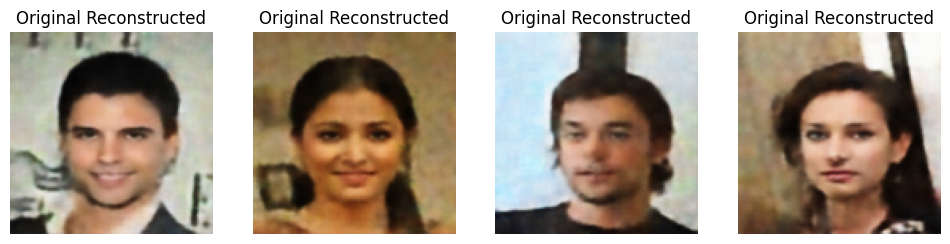

In [78]:
num_images = len(decoded_images)

processed_images = [(img * 255).astype(np.uint8) for img in decoded_images]

fig, axes = plt.subplots(1, num_images, figsize=(12, 5))

for i in range(num_images):
    axes[i].imshow(decoded_images[i])
    axes[i].axis("off")
    axes[i].set_title("Original Reconstructed")

plt.show()


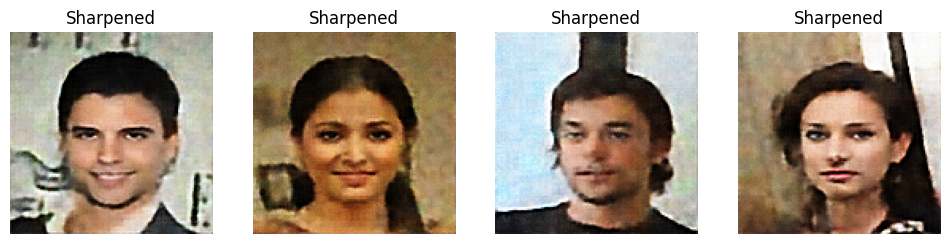

In [79]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

sharpened_images = [cv2.filter2D(img, -1, sharpen_kernel) for img in processed_images]

fig, axes = plt.subplots(1, num_images, figsize=(12, 5))

for i in range(num_images):
    axes[i].imshow(sharpened_images[i])
    axes[i].axis("off")
    axes[i].set_title("Sharpened")

plt.show()


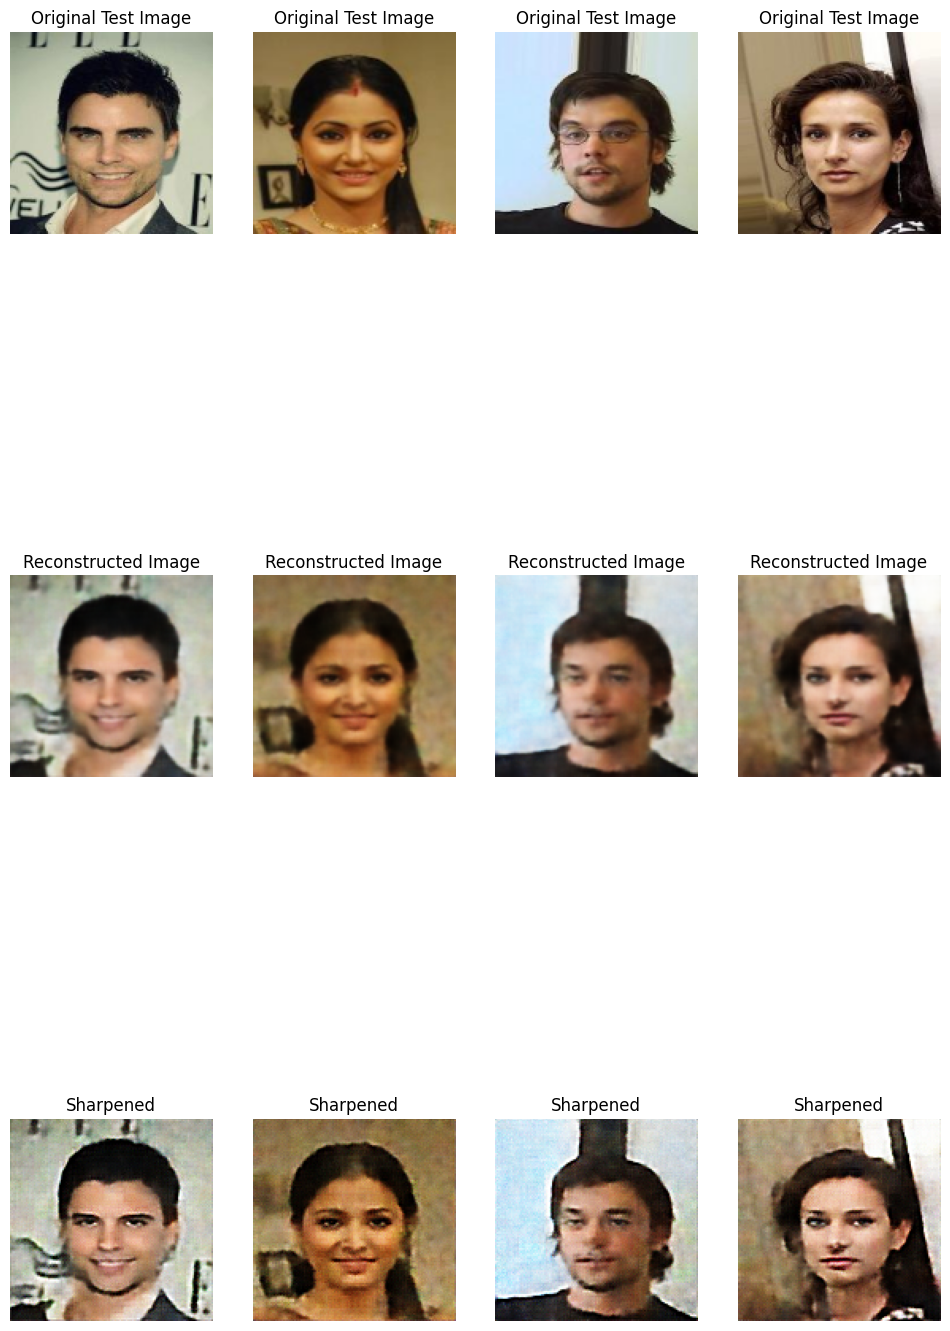

In [80]:
fig, axes = plt.subplots(3, num_images, figsize=(12, 20))

for i in range(num_images):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Original Test Image")

    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed Image")

    axes[2, i].imshow(sharpened_images[i])
    axes[2, i].axis("off")
    axes[2, i].set_title("Sharpened")

plt.show()
